In [43]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.feature_selection import SelectPercentile 


In [44]:
# # Load Data from folds 1-4

# # Make sure the working directory is the same as the script

# files = glob.glob('negative_polarity/deceptive_from_MTurk/fold1/*.txt')
# files += glob.glob('negative_polarity/deceptive_from_MTurk/fold2/*.txt')
# files += glob.glob('negative_polarity/deceptive_from_MTurk/fold3/*.txt')
# files += glob.glob('negative_polarity/deceptive_from_MTurk/fold4/*.txt')


# deceptive = pd.DataFrame(columns=['text'])   
# for file in files:
#     with open(file, 'r') as f:
#             text = f.read()
#             deceptive = pd.concat([deceptive, pd.DataFrame({'text': [text]})], ignore_index=True)


# files = glob.glob('negative_polarity/truthful_from_Web/fold1/*.txt')
# files += glob.glob('negative_polarity/truthful_from_Web/fold2/*.txt')
# files += glob.glob('negative_polarity/truthful_from_Web/fold3/*.txt')
# files += glob.glob('negative_polarity/truthful_from_Web/fold4/*.txt')

# truthful = pd.DataFrame(columns=['text'])
# for file in files:
#     with open(file, 'r') as f:
#             text = f.read()
#             truthful = pd.concat([truthful, pd.DataFrame({'text': [text]})], ignore_index=True)

# deceptive['label'] = 0
# truthful['label'] = 1

# train = pd.concat([deceptive, truthful], ignore_index=True)

# files = glob.glob('negative_polarity/deceptive_from_MTurk/fold5/*.txt')
# deceptive_test = pd.DataFrame(columns=['text']) 
# for file in files:
#     with open(file, 'r') as f:
#             text = f.read()
#             deceptive_test = pd.concat([deceptive_test, pd.DataFrame({'text': [text]})], ignore_index=True)


# files = glob.glob('negative_polarity/truthful_from_Web/fold5/*.txt')
# truthful_test = pd.DataFrame(columns=['text'])
# for file in files:
#     with open(file, 'r') as f:
#             text = f.read()
#             truthful_test = pd.concat([truthful_test, pd.DataFrame({'text': [text]})], ignore_index=True)

# deceptive_test['label'] = 0
# truthful_test['label'] = 1

# test = pd.concat([deceptive_test, truthful_test], ignore_index=True)



In [45]:
# train.to_csv('train.csv', index=False)
# test.to_csv('test.csv', index=False)

In [46]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [47]:
all_models = {}

### BOW Unigrams No Normalisation

In [48]:
# Bag of words with unigrams
text_clf = Pipeline([
    ('vect', CountVectorizer())
])

X_train = text_clf.fit_transform(train['text'])
X_test = text_clf.transform(test['text'])

X_train = X_train.toarray()
X_test = X_test.toarray()

X_train = pd.DataFrame(X_train, columns=text_clf.named_steps['vect'].get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=text_clf.named_steps['vect'].get_feature_names_out())

y_train = train['label']
y_test = test['label']





In [49]:
# Create Models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Tune hyperparameters
param_grid = {
    'Naive Bayes': {},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [1, 2, 5, 10, 100], 'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.5], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'max_depth': [1, 5, 10], 'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5, 10]}
}

for model_name, model in models.items():
    print(f'Training {model_name}')
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')
    models[model_name] = grid_search.best_estimator_



Training Naive Bayes
Best parameters: {}
Best score: 0.8265625
Training Logistic Regression
Best parameters: {'C': 1}
Best score: 0.8484375
Training Decision Tree
Best parameters: {'ccp_alpha': 0.0, 'max_depth': 1, 'min_samples_split': 2}
Best score: 0.7078125
Training Random Forest


KeyboardInterrupt: 

In [ ]:

all_models["unigram-no-normalization"] = models

In [ ]:
from scipy.stats import chi2

from statsmodels.stats.contingency_tables import mcnemar
def mcnemar_test_models(preds1, preds2, y):
    # Generate predictions for both models
    
    # Calculate discordant pairs
    
    a = sum((preds1 == y) & (preds2 == y))  # Both models classify correctly
    b = sum((preds1 == y) & (preds2 != y))  # Model 1 misclassifies, model 2 classifies correctly
    c = sum((preds1 != y) & (preds2 == y))  # Model 1 classifies correctly, model 2 misclassifies
    d = sum((preds1 != y) & (preds2 != y))  # Both models misclassify
    
    m = [[a, b], [c, d]]
    return mcnemar(m)


In [ ]:
# Evaluate models
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    result = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred)],
        'Recall': [recall_score(y_test, y_pred)],
        'F1': [f1_score(y_test, y_pred)]    
    })
    results = pd.concat([results, result], ignore_index=True)

print(results)


                 Model  Accuracy  Precision  Recall        F1
0          Naive Bayes   0.81250   0.867647  0.7375  0.797297
1  Logistic Regression   0.86250   0.862500  0.8625  0.862500
2        Decision Tree   0.64375   0.635294  0.6750  0.654545
3        Random Forest   0.80000   0.800000  0.8000  0.800000


In [ ]:
# Feature importance
print('Feature Importance: Random Forest')
feature_importance_rf = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_rf['Feature'] = X_train.columns
feature_importance_rf['Importance'] = models['Random Forest'].feature_importances_
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
print(feature_importance_rf.head(10))

print('\nFeature Importance: Decision Tree')
feature_importance_dt = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_dt['Feature'] = X_train.columns
feature_importance_dt['Importance'] = models['Decision Tree'].feature_importances_
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False)
print(feature_importance_dt.head(10))

Feature Importance: Random Forest
       Feature  Importance
1193   chicago    0.007801
4847  recently    0.005108
3631  location    0.004932
1699   decided    0.004907
4005        my    0.004813
3696    luxury    0.004519
5313    seemed    0.004084
2454   finally    0.004057
587         at    0.003930
6643    walked    0.003883

Feature Importance: Decision Tree
          Feature  Importance
1193      chicago         1.0
0              00         0.0
4586          ppl         0.0
4597     prefered         0.0
4596   preferably         0.0
4595       prefer         0.0
4594  predicament         0.0
4593      precise         0.0
4592     precious         0.0
4591          pre         0.0


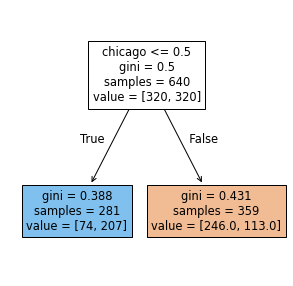

In [ ]:
# Plot DT
plt.figure(figsize=(5, 5))
plot_tree(models['Decision Tree'], filled=True, feature_names=X_train.columns)
plt.show()

### BOW Unigrams with Normalisation and Feature Selection

In [ ]:
# Bag of words with normalisation

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

X_train = text_clf.fit_transform(train['text'])
X_test = text_clf.transform(test['text'])

X_train = X_train.toarray()
X_test = X_test.toarray()

X_train = pd.DataFrame(X_train, columns=text_clf.named_steps['vect'].get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=text_clf.named_steps['vect'].get_feature_names_out())

y_train = train['label']
y_test = test['label']

selector = SelectPercentile(percentile=10)
selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]



In [ ]:

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Tune hyperparameters

param_grid = {
    'Naive Bayes': {},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [1, 2, 5, 10, 100], 'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.5], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'max_depth': [1, 5, 10], 'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5, 10]}
}

for model_name, model in models.items():
    print(f'Training {model_name}')
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')
    models[model_name] = grid_search.best_estimator_

all_models["unigram-with-normalization"] = models


Training Naive Bayes
Best parameters: {}
Best score: 0.8859375
Training Logistic Regression
Best parameters: {'C': 10}
Best score: 0.9171875
Training Decision Tree
Best parameters: {'ccp_alpha': 0.0, 'max_depth': 1, 'min_samples_split': 2}
Best score: 0.725
Training Random Forest
Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 1000}
Best score: 0.8671875


In [ ]:
# Evaluate models

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    result = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred)],
        'Recall': [recall_score(y_test, y_pred)],
        'F1': [f1_score(y_test, y_pred)]
    })
    results = pd.concat([results, result], ignore_index=True)

print(results)


                 Model  Accuracy  Precision  Recall        F1
0          Naive Bayes   0.85000   0.900000  0.7875  0.840000
1  Logistic Regression   0.85625   0.820225  0.9125  0.863905
2        Decision Tree   0.63125   0.612903  0.7125  0.658960
3        Random Forest   0.83125   0.791209  0.9000  0.842105


In [ ]:
# Get feature importance
print('Feature Importance: Random Forest')
feature_importance_rf = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_rf['Feature'] = X_train.columns
feature_importance_rf['Importance'] = models['Random Forest'].feature_importances_
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
print(feature_importance_rf.head(10))

print('\nFeature Importance: Decision Tree')
feature_importance_dt = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_dt['Feature'] = X_train.columns
feature_importance_dt['Importance'] = models['Decision Tree'].feature_importances_
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False)
print(feature_importance_dt.head(10))

Feature Importance: Random Forest
      Feature  Importance
110   chicago    0.040280
656       was    0.018605
386        my    0.017852
74         be    0.014930
52         at    0.013751
339  location    0.013404
234   finally    0.011703
548     smell    0.011472
668      when    0.010228
470  recently    0.010199

Feature Importance: Decision Tree
      Feature  Importance
110   chicago         1.0
463     quiet         0.0
455  properly         0.0
456  property         0.0
457      pros         0.0
458    public         0.0
459       put         0.0
460   putting         0.0
461    queens         0.0
462     quick         0.0


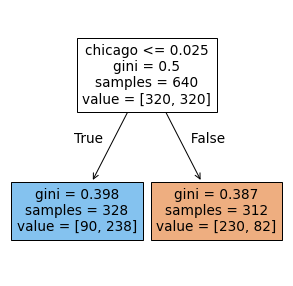

In [ ]:
# Plot DT
plt.figure(figsize=(5, 5))
plot_tree(models['Decision Tree'], filled=True, feature_names=X_train.columns)
plt.show()

### BOW With Bigrams No Normalisation

In [ ]:
# Bag of Words with bigrams

text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2)))    
])

X_train = text_clf.fit_transform(train['text'])
X_test = text_clf.transform(test['text'])

X_train = X_train.toarray()
X_test = X_test.toarray()

X_train = pd.DataFrame(X_train, columns=text_clf.named_steps['vect'].get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=text_clf.named_steps['vect'].get_feature_names_out())

y_train = train['label']
y_test = test['label']

In [ ]:
# Tune hyperparameters

param_grid = {
    'Naive Bayes': {},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [1, 2, 5, 10, 100], 'ccp_alpha': [0.0, 0.1, 0.3, 0.5], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'max_depth': [1, 5, 10], 'n_estimators': [100, 1000], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5]}
}

for model_name, model in models.items():
    print(f'Training {model_name}')
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')
    models[model_name] = grid_search.best_estimator_
    

all_models["bigram-no-normalization"] = models

Training Naive Bayes
Best parameters: {}
Best score: 0.8015625
Training Logistic Regression
Best parameters: {'C': 1}
Best score: 0.8515625
Training Decision Tree
Best parameters: {'ccp_alpha': 0.0, 'max_depth': 1, 'min_samples_split': 2}
Best score: 0.7078125
Training Random Forest
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 1000}
Best score: 0.8296875


In [ ]:
# Evaluate models

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    result = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred)],
        'Recall': [recall_score(y_test, y_pred)],
        'F1': [f1_score(y_test, y_pred)]
    })
    results = pd.concat([results, result], ignore_index=True)

print(results)

                 Model  Accuracy  Precision  Recall        F1
0          Naive Bayes   0.83750   0.921875  0.7375  0.819444
1  Logistic Regression   0.82500   0.788889  0.8875  0.835294
2        Decision Tree   0.64375   0.641975  0.6500  0.645963
3        Random Forest   0.83750   0.800000  0.9000  0.847059


In [ ]:
# Feature importance
print('Feature Importance: Random Forest')
feature_importance_rf = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_rf['Feature'] = X_train.columns
feature_importance_rf['Importance'] = models['Random Forest'].feature_importances_
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
print(feature_importance_rf.head(10))

print('\nFeature Importance: Decision Tree')
feature_importance_dt = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_dt['Feature'] = X_train.columns
feature_importance_dt['Importance'] = models['Decision Tree'].feature_importances_
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False)
print(feature_importance_dt.head(10))

Feature Importance: Random Forest
        Feature  Importance
9711    chicago    0.013544
26790  location    0.005818
37226  recently    0.005545
27321    luxury    0.005380
29744   my room    0.004622
41460     smell    0.004170
16968   finally    0.003879
5087     at the    0.003864
39834    seemed    0.003717
29484        my    0.003570

Feature Importance: Decision Tree
                     Feature  Importance
9711                 chicago         1.0
0                         00         0.0
37227  recently additionally         0.0
37216                 recent         0.0
37217        recent business         0.0
37218          recent family         0.0
37219      recent renovation         0.0
37220            recent stay         0.0
37221            recent syat         0.0
37222            recent trip         0.0


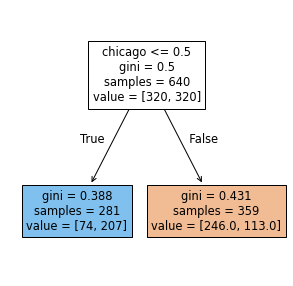

In [ ]:
# Plot DT
plt.figure(figsize=(5, 5))
plot_tree(models['Decision Tree'], filled=True, feature_names=X_train.columns)
plt.show()

### BOW Bigrams With Normalisation

In [ ]:
# Bag of Words with vectorised bigrams

text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer())  
])

X_train = text_clf.fit_transform(train['text'])
X_test = text_clf.transform(test['text'])

X_train = X_train.toarray()
X_test = X_test.toarray()

X_train = pd.DataFrame(X_train, columns=text_clf.named_steps['vect'].get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=text_clf.named_steps['vect'].get_feature_names_out())

y_train = train['label']
y_test = test['label']

selector = SelectPercentile(percentile=2)
selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]

In [ ]:
X_train.shape

(640, 1117)

In [ ]:
# Tune hyperparameters

param_grid = {
    'Naive Bayes': {},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100, 250, 500]},
    'Decision Tree': {'max_depth': [1, 2, 5, 10, 100], 'ccp_alpha': [0.0, 0.1, 0.3, 0.5], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'max_depth': [1, 5, 10], 'n_estimators': [100, 1000], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5]}
}

for model_name, model in models.items():
    print(f'Training {model_name}')
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')
    models[model_name] = grid_search.best_estimator_
    
    
all_models["bigram-with-normalization"] = models

Training Naive Bayes
Best parameters: {}
Best score: 0.9296875
Training Logistic Regression
Best parameters: {'C': 100}
Best score: 0.94375
Training Decision Tree
Best parameters: {'ccp_alpha': 0.0, 'max_depth': 1, 'min_samples_split': 2}
Best score: 0.7171875
Training Random Forest
Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 1000}
Best score: 0.8625


In [ ]:
# Evaluate models

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    result = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred)],
        'Recall': [recall_score(y_test, y_pred)],
        'F1': [f1_score(y_test, y_pred)]
    })
    results = pd.concat([results, result], ignore_index=True)

print(results)

                 Model  Accuracy  Precision  Recall        F1
0          Naive Bayes   0.81250   0.867647  0.7375  0.797297
1  Logistic Regression   0.86250   0.862500  0.8625  0.862500
2        Decision Tree   0.64375   0.635294  0.6750  0.654545
3        Random Forest   0.80000   0.800000  0.8000  0.800000


In [ ]:
# Feature importance
print('Feature Importance: Random Forest')
feature_importance_rf = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_rf['Feature'] = X_train.columns
feature_importance_rf['Importance'] = models['Random Forest'].feature_importances_
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
print(feature_importance_rf.head(10))

print('\nFeature Importance: Decision Tree')
feature_importance_dt = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_dt['Feature'] = X_train.columns
feature_importance_dt['Importance'] = models['Decision Tree'].feature_importances_
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False)
print(feature_importance_dt.head(10))

Feature Importance: Random Forest
            Feature  Importance
164         chicago    0.035434
96           at the    0.015797
542              my    0.011966
1004            was    0.010298
766           smell    0.010208
471        location    0.009761
113              be    0.008730
1024        was not    0.008639
488          luxury    0.008295
167   chicago hotel    0.008066

Feature Importance: Decision Tree
         Feature  Importance
164      chicago         1.0
0     10th floor         0.0
743     security         0.0
748         sell         0.0
747   seems like         0.0
746    seemed to         0.0
745  seemed like         0.0
744       seemed         0.0
742       second         0.0
750   service is         0.0


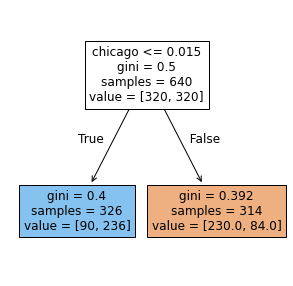

In [ ]:
# Plot DT
plt.figure(figsize=(5, 5))
plot_tree(models['Decision Tree'], filled=True, feature_names=X_train.columns)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from statsmodels.stats.contingency_tables import mcnemar

def mcnemar_test(model1, model2, X_test, y_test):
    # Generate predictions for both models
    preds1 = model1.predict(X_test)
    preds2 = model2.predict(X_test)
    
    # Calculate discordant pairs
    b = sum((preds1 == y_test) & (preds2 != y_test))  # Model 1 correct, Model 2 incorrect
    c = sum((preds1 != y_test) & (preds2 == y_test))  # Model 1 incorrect, Model 2 correct
    
    # Create contingency table
    table = [[0, b], [c, 0]]
    
    # Perform McNemar test
    result = mcnemar(table, exact=True)
    
    return result

# Example usage:
# result = mcnemar_test(trained_model1, trained_model2, X_test, y_test)
# print('McNemar test statistic:', result.statistic)
# print('p-value:', result.pvalue)

In [ ]:
def get_mcnemar_results(models):
    results = {}
    for model_data_name, models_by_dataset in models.values():
        for model_name, model in models_by_dataset.items():
            for model_name2, model2 in models_by_dataset.items():
                if model_name == model_name2:
                    continue
                if (model_name2, model_name) in results:
                    continue
                results[(model_data_name, model_name, model_name2)] = str(mcnemar_test(model, model2, X_test, y_test))
        
        #print(f'{model_name} confusion matrix')
        #print(confusion_matrix(y_test, y_pred))
       # print(f' mcnemar test between: {model_name} and {model_name2}')
        #(mcnemar_test(model, model2, X_test, y_test))
        #(mcnemar_test_models(model.predict(X_test), model2.predict(X_test), y_test))
       # print('\n')
    return results

print(models_by_dataset)
